### Get data from S3

In [561]:
import pandas as pd
import numpy  as np
import boto3
import os
import re

from io import StringIO

BUCKET_NAME       = 'scraper-batdongsan'
ACCESS_KEY        = os.environ.get('ACCESS_KEY_ID')
ACCESS_SECRET_KEY = os.environ.get('ACCESS_SECRET_KEY')

In [562]:
# Connect client to access all items in bucket
client = boto3.client('s3', aws_access_key_id=ACCESS_KEY, aws_secret_access_key=ACCESS_SECRET_KEY)
objs   = client.list_objects(Bucket=BUCKET_NAME)['Contents']

# Read data
col = {'uid':'object', 
       'prid':'object', 
       'url':'object', 
       'title_raw':'object', 
       'price_raw':'object',
       'area_raw':'object',
       'bedroom_raw':'object', 
       'toilet_raw':'object', 
       'location_raw':'object', 
       'content_raw':'object', 
       'post_date':'object',
       'scrape_timestamp':'object'}

date_cols = ['post_date', 'scrape_timestamp']

data = []
for obj in objs:
    try:
        csv_obj = client.get_object(Bucket=BUCKET_NAME, Key=obj['Key'])
        body = csv_obj['Body'].read().decode('utf-8')
        temp = pd.read_csv(StringIO(body), header=0, sep=',', dtype=col, parse_dates=date_cols) 
        data.append(temp)
    except:
        print("Reading {} failed".format(obj['Key']))

In [563]:
# Merge
df = pd.concat(data)
df.head(3)

,uid,prid,url,title_raw,price_raw,area_raw,bedroom_raw,toilet_raw,location_raw,content_raw,post_date,scrape_timestamp
0,505160,29056483,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,BT 200 - 400m2 The Phoenix Garden LH: 0918756788,Giá thỏa thuận,200 m²,NaN,NaN,"Đan Phượng, Hà Nội",\n TÃ´i cÃ³ cÄn 20...,2021-04-14,2021-04-15 03:10:18.599043
1,1533707,29134056,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,Chính chủ bán biệt thự Pháp cổ full nội thất K...,27 tỷ,99 m²,NaN,NaN,"Hoàn Kiếm, Hà Nội",\n NhÃ sá» 8 phá»...,2021-04-14,2021-04-15 03:10:18.599043
2,1498902,29462008,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,Nhận đặt chỗ quỹ căn góc đẹp nhất khu C dự án ...,Giá thỏa thuận,300 m²,NaN,NaN,"Thạch Thất, Hà Nội",\n Quá»¹ cÄn gÃ³c ...,2021-04-14,2021-04-15 03:10:18.599043


### Extract more info

In [564]:
def convertPrice(price, area):
    '''Convert price format'''
    try:
        price=str(price); area=str(area)
        if price == "Giá thỏa thuận":
            return None
        elif price.split(" ")[1]=="nghìn/m²":
                return float(re.match("(.*?) nghìn/m²", price).group(1))*float(re.match("(.*?) m²", area).group(1))*1000
        elif price.split(" ")[1]=="triệu/m²":
                return float(re.match("(.*?) triệu/m²", price).group(1))*float(re.match("(.*?) m²", area).group(1))*1000000
        elif price.split(" ")[1]=="tỷ/m²":
                return float(re.match("(.*?) tỷ/m²", price).group(1))*float(re.match("(.*?) m²", area).group(1))*1000000000
        elif price.split(" ")[1]=="nghìn":
            return float(re.match("(.*?) nghìn", price).group(1))*1000
        elif price.split(" ")[1]=="triệu":
            return float(re.match("(.*?) triệu", price).group(1))*1000000
        elif price.split(" ")[1]=="tỷ":
            return float(re.match("(.*?) tỷ", price).group(1))*1000000000
        else:
            return price #this or None?
    except:
        return None

def getArea(area):
    '''Get area as float'''
    try: return float(re.match("(.*?) m²", str(area)).group(1))
    except: return None
    
def getBed(bed):
    '''Get bedroom as float'''
    try: return float(re.match("(.*?) PN", str(bed)).group(1))
    except: return None
    
def getBath(bath):
    '''Get bathroom as float'''
    try: return float(re.match("(.*?) WC", str(bath)).group(1))
    except: return None

In [565]:
# Location
df['district']  = df.apply(lambda x: x['location_raw'].split(", ")[0], axis=1)
df['city']      = df.apply(lambda x: x['location_raw'].split(", ")[1], axis=1)

# Size
df['area_m2'] = df.apply(lambda x: getArea(x['area_raw']), axis=1)
df['bed']     = df.apply(lambda x: getBed(x['bedroom_raw']), axis=1)
df['bath']    = df.apply(lambda x: getBath(x['toilet_raw']), axis=1)

# Days since posted
df['days_since_posted'] = (df['scrape_timestamp']-df['post_date']).apply(lambda x: x.days)

# Prices
df['price_vnd']  = df.apply(lambda x: convertPrice(x['price_raw'], x['area_raw']), axis=1)
df['price_usd']  = df['price_vnd']*0.000043 #VND -> USD
df['usd_per_m2'] = df['price_usd']/df['area_m2']

In [566]:
print(df.dtypes)
df.head(3)

uid                          object
prid                         object
url                          object
title_raw                    object
price_raw                    object
area_raw                     object
bedroom_raw                  object
toilet_raw                   object
location_raw                 object
content_raw                  object
post_date            datetime64[ns]
scrape_timestamp     datetime64[ns]
district                     object
city                         object
area_m2                     float64
bed                         float64
bath                        float64
days_since_posted             int64
price_vnd                   float64
price_usd                   float64
usd_per_m2                  float64
dtype: object


,uid,prid,url,title_raw,price_raw,area_raw,bedroom_raw,toilet_raw,location_raw,content_raw,...,scrape_timestamp,district,city,area_m2,bed,bath,days_since_posted,price_vnd,price_usd,usd_per_m2
0,505160,29056483,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,BT 200 - 400m2 The Phoenix Garden LH: 0918756788,Giá thỏa thuận,200 m²,NaN,NaN,"Đan Phượng, Hà Nội",\n TÃ´i cÃ³ cÄn 20...,...,2021-04-15 03:10:18.599043,Đan Phượng,Hà Nội,200.0,NaN,NaN,1,NaN,NaN,NaN
1,1533707,29134056,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,Chính chủ bán biệt thự Pháp cổ full nội thất K...,27 tỷ,99 m²,NaN,NaN,"Hoàn Kiếm, Hà Nội",\n NhÃ sá» 8 phá»...,...,2021-04-15 03:10:18.599043,Hoàn Kiếm,Hà Nội,99.0,NaN,NaN,1,2.700000e+10,1161000.0,11727.272727
2,1498902,29462008,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,Nhận đặt chỗ quỹ căn góc đẹp nhất khu C dự án ...,Giá thỏa thuận,300 m²,NaN,NaN,"Thạch Thất, Hà Nội",\n Quá»¹ cÄn gÃ³c ...,...,2021-04-15 03:10:18.599043,Thạch Thất,Hà Nội,300.0,NaN,NaN,1,NaN,NaN,NaN


In [567]:
df.groupby(['city', 'district'])['prid'].nunique().reset_index(name='unique_listings').sort_values(by=['city', 'unique_listings'],ascending=False)

,city,district,unique_listings
42,Hồ Chí Minh,Quận 2,884
49,Hồ Chí Minh,Quận 9,847
50,Hồ Chí Minh,Thủ Đức,684
47,Hồ Chí Minh,Quận 7,671
51,Hồ Chí Minh,Tân Bình,432
52,Hồ Chí Minh,Tân Phú,416
30,Hồ Chí Minh,Bình Thạnh,409
34,Hồ Chí Minh,Gò Vấp,351
41,Hồ Chí Minh,Quận 12,346
36,Hồ Chí Minh,Nhà Bè,345


In [568]:
# remove invalid prices
# df = df[~df['price_vnd'].astype('str').str.contains('/')]

### Price Distribution

It is possible to have same listing for the same scrape since pages get updated in real time.

In [569]:
# Keep first reading for each listing-scrape
data = df.drop_duplicates(subset=['uid', 'prid', 'scrape_timestamp'], keep='first')
print('{} out of {} listings were unique.'.format(data.shape[0], df.shape[0]))

17531 out of 17920 listings were unique.


In [570]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12,9)})
sns.set_theme(style='whitegrid')

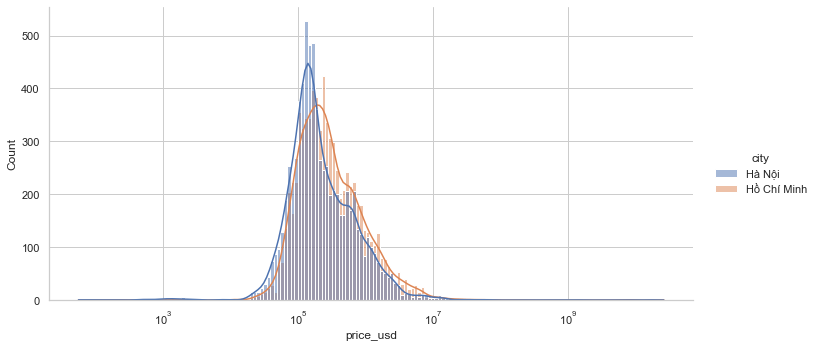

In [571]:
ax = sns.displot(data=data, x='price_usd',  hue='city', log_scale=True, kde=True, aspect=2) #logged

Log(Price) shows rightly skewed distribution, meaning most listings fall below the mean price. There are big estates that are pushing the prices. HCM real estates are more skewed right (more expensive listings with more frequency).

### Prices by District

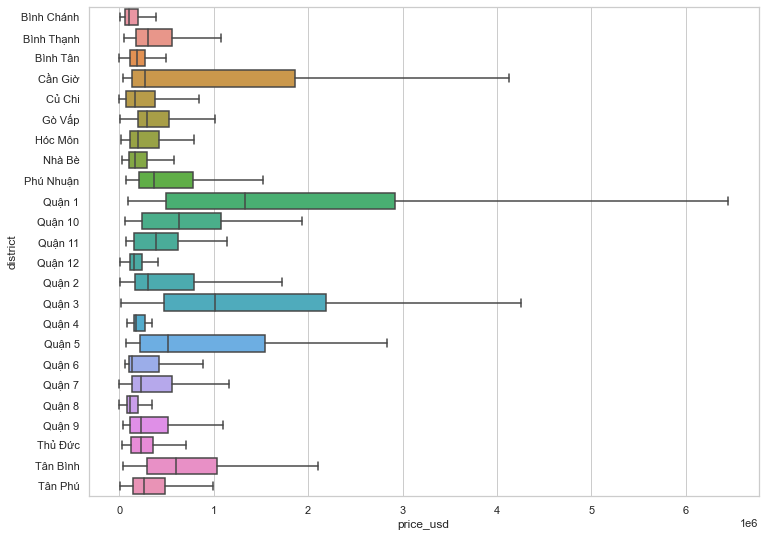

In [572]:
hcm = data[data['city']=='Hồ Chí Minh']

#https://stackoverflow.com/questions/35131798/tweaking-seaborn-boxplot
ax = sns.boxplot(y='district', 
                 x='price_usd',
                 data=hcm, 
                 orient='h',
                 order=sorted(hcm['district'].unique()),
                 showfliers=False)

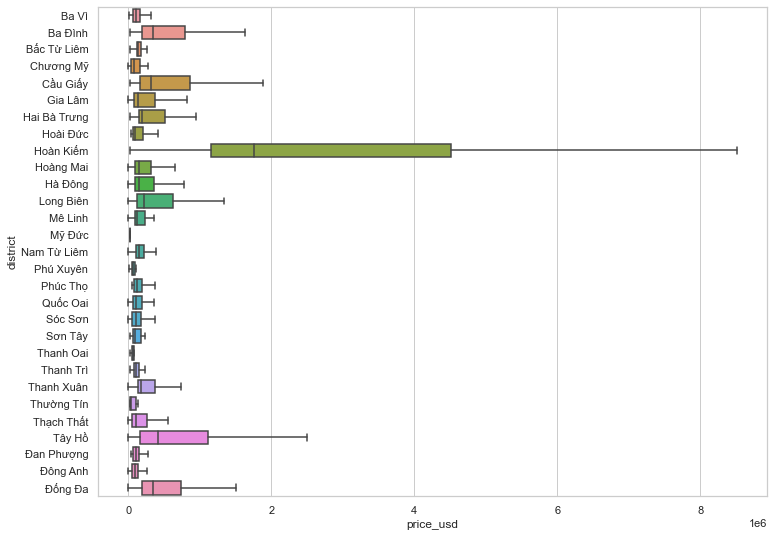

In [573]:
hn = data[data['city']=='Hà Nội']

ax = sns.boxplot(y='district', 
                 x='price_usd',
                 data=hn, 
                 orient='h',
                 order=sorted(hn['district'].unique()),
                 showfliers=False)

### Prices per m2

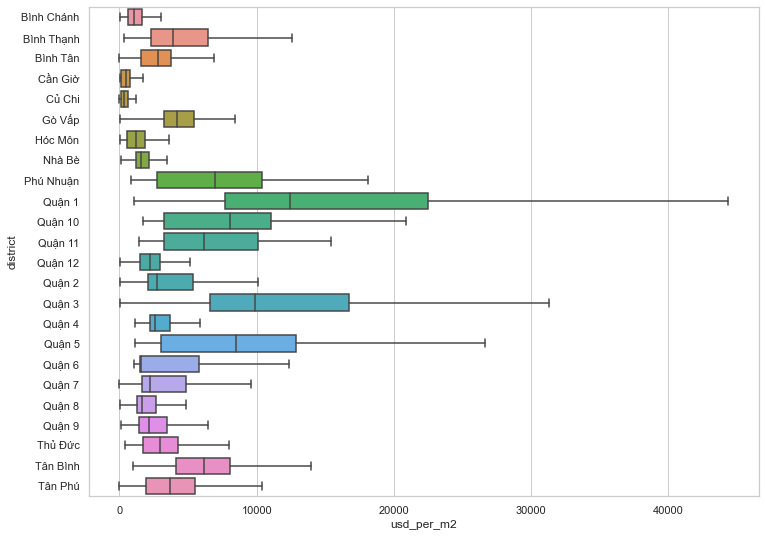

In [574]:
ax = sns.boxplot(y='district', 
                 x='usd_per_m2',
                 data=hcm, 
                 orient='h',
                 order=sorted(hcm['district'].unique()),
                 showfliers=False)

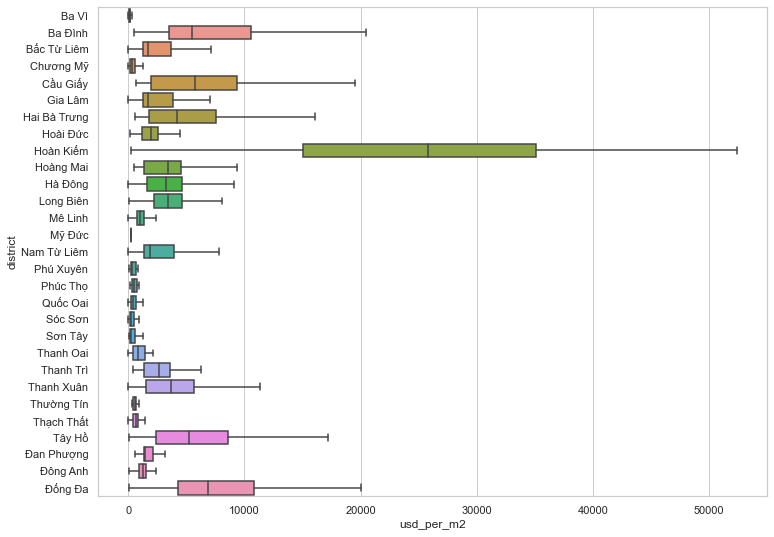

In [575]:
ax = sns.boxplot(y='district', 
                 x='usd_per_m2',
                 data=hn, 
                 orient='h',
                 order=sorted(hn['district'].unique()),
                 showfliers=False)

### Calculate Price Index

In [602]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

reg = LinearRegression()

In [603]:
train_df = hcm.dropna()
train_df.describe()

,area_m2,bed,bath,days_since_posted,price_vnd,price_usd,usd_per_m2
count,738.000000,738.000000,738.000000,738.000000,7.380000e+02,7.380000e+02,738.000000
mean,116.192168,3.346883,3.203252,3.753388,8.378202e+09,3.602627e+05,3601.780319
std,476.533765,2.920753,3.087048,3.148758,1.251645e+10,5.382075e+05,2951.351000
min,23.000000,1.000000,1.000000,0.000000,5.000000e+06,2.150000e+02,4.300000
25%,58.500000,2.000000,2.000000,1.000000,2.950000e+09,1.268500e+05,1748.211115
50%,75.000000,3.000000,2.000000,3.000000,5.000000e+09,2.150000e+05,2659.857143
75%,105.000000,4.000000,4.000000,6.000000,7.900000e+09,3.397000e+05,4536.078431
max,12500.000000,42.000000,43.000000,19.000000,1.800000e+11,7.740000e+06,42025.495751


In [630]:
continuous  = ['area_m2', 'bed', 'bath', 'days_since_posted']
categorical = ['district']

# Get X
# first, get dummies
dummy_df = pd.get_dummies(train_df[categorical], prefix='', prefix_sep='').drop('Quận 12', 1)
# Quận 12 is our baseline dummy
# keeping index is important in merging categorical dummies back
X = pd.concat([train_df[continuous], dummy_df.set_index(train_df.index)], axis=1) 
print(X.shape[0])

# Get y
y = np.log(train_df['price_usd']) #Logged to conform with normal assumption
print(len(y))

738
738


In [631]:
# Split 90:10
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

In [632]:
reg.fit(x_train, y_train)

LinearRegression()

In [633]:
reg.score(x_test, y_test)

0.5642320043009406

Decent accuracy at the moment but could get better with more data.

In [634]:
reg.coef_

array([ 3.89369156e-04, -2.35722944e-02,  1.27842526e-01,  6.53670512e-03,
       -1.43240862e-01,  7.74323494e-01, -2.83786462e-01, -8.13442074e-01,
        6.28602410e-01,  1.99256666e-01, -1.25804841e-01,  7.15050013e-01,
        8.63692206e-01,  7.11555047e-01,  7.97081949e-01,  8.14564189e-01,
        8.20734520e-01,  2.26765349e-01,  2.38702314e-01,  7.12820083e-01,
        2.71521546e-01, -1.76775952e-02,  4.62391990e-01,  5.70814414e-01,
        8.45757651e-01,  7.01951354e-01])

#### Just making sure that coefficients from Statsmodel and Sklearn regressions look the same...

In [635]:
import statsmodels.api as sm

X2 = sm.add_constant(x_train)
est = sm.OLS(y_train,X2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_usd   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     18.78
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           2.73e-62
Time:                        15:28:07   Log-Likelihood:                -652.28
No. Observations:                 664   AIC:                             1359.
Df Residuals:                     637   BIC:                             1480.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.5044      0.131     88.114      0.000      11.248      11.761
area_m2               0.0004   5.88e-05      6.621      0.000       0.000       0.001
bed                  -0.0236      0.037     -0.640      0.522      -0.096       0.049
bath                  0.1278      0.035      3.656      0.000       0.059       0.197
days_since_posted     0.0065      0.008      0.792      0.429      -0.010       0.023
Bình Chánh           -0.1432      0.202     -0.708      0.479      -0.541       0.254
Bình Thạnh            0.7743      0.157      4.942      0.000       0.467       1.082
Bình Tân             -0.2838      0.176     -1.608      0.108      -0.630       0.063
Củ Chi               -0.8134      0.398     -2.043      0.041      -1.595      -0.032
Gò Vấp                0.6286      0.162      3.881      0.000       0.311       0.947
Hóc Môn               0.1993      0.673      0.296      0.767      -1.123       1.521
Nhà Bè               -0.1258      0.160     -0.788      0.431      -0.439       0.188
Phú Nhuận             0.7151      0.189      3.775      0.000       0.343       1.087
Quận 1                0.8637      0.212      4.067      0.000       0.447       1.281
Quận 10               0.7116      0.190      3.754      0.000       0.339       1.084
Quận 11               0.7971      0.402      1.984      0.048       0.008       1.586
Quận 2                0.8146      0.139      5.856      0.000       0.541       1.088
Quận 3                0.8207      0.264      3.113      0.002       0.303       1.339
Quận 4                0.2268      0.264      0.860      0.390      -0.291       0.745
Quận 5                0.2387      0.265      0.901      0.368      -0.282       0.759
Quận 6                0.7128      0.264      2.701      0.007       0.195       1.231
Quận 7                0.2715      0.147      1.850      0.065      -0.017       0.560
Quận 8               -0.0177      0.167     -0.106      0.916      -0.346       0.311
Quận 9                0.4624      0.158      2.934      0.003       0.153       0.772
Thủ Đức               0.5708      0.147      3.882      0.000       0.282       0.860
Tân Bình              0.8458      0.184      4.588      0.000       0.484       1.208
Tân Phú               0.7020      0.182      3.862      0.000       0.345       1.059
==============================================================================
Omnibus:                      195.041   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4769.267
Skew:                          -0.716   Prob(JB):                         0.00
Kurtosis:                      16.051   Cond. No.                     1.41e+04
==============================================================================

Notes:
[1] Standard Errors a

In [646]:
pd.DataFrame(zip(X.columns, reg.coef_, round(est.pvalues, 2), (np.exp(reg.coef_)-1)*100),
             columns=['var', 'log_lin_coef', 'p_value', 'interpretation'])

,var,log_lin_coef,p_value,interpretation
0,area_m2,0.000389,0.00,0.038944
1,bed,-0.023572,0.00,-2.329664
2,bath,0.127843,0.52,13.637404
3,days_since_posted,0.006537,0.00,0.655812
4,Bình Chánh,-0.143241,0.43,-13.345467
5,Bình Thạnh,0.774323,0.48,116.912420
6,Bình Tân,-0.283786,0.00,-24.707259
7,Củ Chi,-0.813442,0.11,-55.667054
8,Gò Vấp,0.628602,0.04,87.498828
9,Hóc Môn,0.199257,0.00,22.049519


With Bình Thạnh as the baseline district, keeping all else equal, a listing in in Quận 10 is about 104% more expensive.

### Post Title and Content

In [761]:
import string

from underthesea import classify, word_tokenize
from collections import defaultdict

Try out Underthesea's classification function (their data comes from Baomoi, so topics still limited):

In [808]:
for i in data['title_raw'][:10]:
    print("{}: {}".format(classify(i), i))

['vi_tinh']:  BT 200 - 400m2 The Phoenix Garden LH: 0918756788
['doi_song']: Chính chủ bán biệt thự Pháp cổ full nội thất KD nhà hàng tại số 8 Hạ Hồi, DT 99m2, giá 27 tỷ
['chinh_tri_xa_hoi']: Nhận đặt chỗ quỹ căn góc đẹp nhất khu C dự án Xanh Villas diện tích từ 200m2 đến hơn 1000m2
['chinh_tri_xa_hoi']: Bán nhà La Phù, gần Lê Trọng Tấn, cách Aeonmall Hà Đông 1km, ô tô cách 30m
['chinh_tri_xa_hoi']: Quỹ căn tháng 4/2021 shophouse, biệt thự, liền kề Vinhomes Ocean Park giá rẻ
['chinh_tri_xa_hoi']: Bán biệt thự sân vườn dãy D03 An Vượng Villas, vị trí đẹp nhất dự án, view hồ, 13 tỷ. 0989 69 59 54
['chinh_tri_xa_hoi']: Bảng hàng shophouse liền kề, biệt thự Louis City Hoàng Mai mặt đường Tân Mai vị trí đẹp giá gốc CĐT
['kinh_doanh']: Bán biệt thự Louis City Hoàng Mai, siêu phẩm cho khách đầu tư
['chinh_tri_xa_hoi']: Tổng hợp các căn hộ cần chuyển nhượng giá gốc Vinhomes Ocean Park. Liên hệ 0962432084
['doi_song']: Tây Hồ Residence ngay Hồ Tây ra bảng hàng tầng cao 4 mặt view Hồ giá từ 3,3 

In [880]:
def clean_text(text):
    #To remove the punctuations
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
    #will replace newline with space
    text = re.sub('\n',' ',text)
    text = re.sub(' [0-9]+ ',' ',text)
    #will convert to lower case
    text = text.lower()
    # will split and join the words
    text=' '.join(text.split())
    return text

def get_word_freq(df):
    """Return dict of words and count"""
    word_freq = defaultdict(int) #init dict
    for content in df['content_raw']:
        try:
            text = clean_text(content.encode('latin1').decode('utf8')) #special decode
        except:
            text = clean_text(content) #some raw contents don't need decodes
        for word in word_tokenize(text):
            if word not in stopwords_viet:
                word_freq[word] += 1
    
    return word_freq

In [874]:
# Get stopwords for Vietnamese from https://xltiengviet.fandom.com/wiki/Danh_s%C3%A1ch_stop_word
stopwords_viet = np.loadtxt('stopwords_viet.txt',delimiter='\n',dtype=str)
stopwords_viet

array(['bị', 'bởi', 'cả', 'các', 'cái', 'cần', 'càng', 'chỉ', 'chiếc',
       'cho', 'chứ', 'chưa', 'chuyện', 'có', 'có_thể', 'cứ', 'của',
       'cùng', 'cũng', 'đã', 'đang', 'đây', 'để', 'đến_nỗi', 'đều',
       'điều', 'do', 'đó', 'được', 'dưới', 'gì', 'khi', 'không', 'là',
       'lại', 'lên', 'lúc', 'mà', 'mỗi', 'một_cách', 'này', 'nên', 'nếu',
       'ngay', 'nhiều', 'như', 'nhưng', 'những', 'nơi', 'nữa', 'phải',
       'qua', 'ra', 'rằng', 'rằng', 'rất', 'rất', 'rồi', 'sau', 'sẽ',
       'so', 'sự', 'tại', 'theo', 'thì', 'trên', 'trước', 'từ', 'từng',
       'và', 'vẫn', 'vào', 'vậy', 'vì', 'việc', 'với', 'vừa'], dtype='<U8')

In [873]:
eg = data.iloc[0, 9] #content_raw
print('Raw example of encoded content:\n{}'.format(eg))
print('Decoded:\n{}'.format(eg.encode('latin1').decode('utf8')))
print('Tokenized by Underthesea:\n{}\n'.format(word_tokenize(eg.encode('latin1').decode('utf8'))))
print('Tokenized by Underthesea with clean text:\n{}'.format(word_tokenize(clean_text(eg.encode('latin1').decode('utf8')))))

Raw example of encoded content:

 - Cam káº¿t giÃ¡ bÃ¡n ráº» nháº¥t thá» trÆ°á»...
                        
Decoded:

 - Cam kết giá bán rẻ nhất thị trườ...
                        
Tokenized by Underthesea:
['Tôi', 'có', 'căn', '200', 'm2', 'cần', 'bán', 'gấp', ',', 'hỗ trợ', 'tất cả', 'thuế', 'phí', 'mua bán', '.', '-', 'Diện tích', 'xây', ':', '100', 'm2', 'thiết kế', '3', 'tầng', '+', '1', 'tum', ',', 'mẫu', 'biệt thự', 'song', 'lập', 'mới', '.', '-', 'C6A', '-', '04', 'diện tích', '200', 'm2', ',', 'mặt tiền', '8', 'm', ',', 'hướng', 'Tây Bắc', ',', 'vị trí', 'đẹp', '.', 'Đất', 'đồi', 'cao', ',', 'gần', 'hồ', 'trung tâm', ',', 'gần', '2', 'cổng', 'chính', 'đường', 'Tây', 'thăng long', '.', '-', 'Hỗ trợ', 'vay', 'vốn', 'ngân hàng', 'tới', '80', '%', ',', 'chiết khấu', '8', '%', 'giá trị', 'xây', 'thô', '.', '-', 'Cam kết', 'giá', 'bán', 'rẻ', 'nhất', 'thị', 'trườ', '...']

Tokenized by Underthesea with clean text:
['tôi', 'có', 'căn', '200', 'm2', 'cần', 'bán', 'gấp', 'hỗ trợ', '

In [881]:
a = get_word_freq(hcm)
b = get_word_freq(hn)

In [882]:
sorted(a.items(), key=lambda item: item[1], reverse=True)[:30]

[('m', 7159),
 ('bán', 7139),
 ('nhà', 7074),
 ('m2', 5775),
 ('giá', 4937),
 ('đường', 4811),
 ('diện tích', 3913),
 ('tỷ', 3584),
 ('quận', 3540),
 ('đất', 2830),
 ('khu', 2691),
 ('căn hộ', 2645),
 ('vị trí', 2411),
 ('căn', 2345),
 ('lầu', 2273),
 ('chủ', 2250),
 ('mặt tiền', 2226),
 ('pn', 2209),
 ('2', 2192),
 ('đẹp', 2021),
 ('gần', 1815),
 ('chính', 1739),
 ('phường', 1733),
 ('gấp', 1698),
 ('dt', 1630),
 ('hẻm', 1610),
 ('trệt', 1521),
 ('wc', 1447),
 ('phòng', 1444),
 ('sổ', 1415)]

In [884]:
sorted(b.items(), key=lambda item: item[1], reverse=True)[:30]

[('m2', 8411),
 ('nhà', 8394),
 ('bán', 7428),
 ('m', 6697),
 ('tầng', 4839),
 ('diện tích', 4405),
 ('chủ', 3617),
 ('đất', 3331),
 ('đường', 3234),
 ('giá', 3218),
 ('đẹp', 3037),
 ('chính', 2991),
 ('căn', 2769),
 ('căn hộ', 2635),
 ('vị trí', 2527),
 ('khu', 2460),
 ('tỷ', 2458),
 ('mặt tiền', 2410),
 ('gần', 2373),
 ('lô', 2337),
 ('ngõ', 2282),
 ('ô tô', 2216),
 ('ở', 2000),
 ('thiết kế', 1953),
 ('phòng', 1939),
 ('rộng', 1919),
 ('cách', 1878),
 ('xây', 1850),
 ('hà', 1826),
 ('kinh doanh', 1662)]